# Pytorch homework
## 作業說明
這次的作業總共有5個部份，在每一個部份會有一些被註解框起來的區塊需要完成。
1. Preparation: 我們會利用CIFAR-10 dataset **(10%)**
2. Pytorch Module API: 在這邊我們會利用 nn.Module 建構出簡單的CNN（CNN架構請參照我們所提供） **(20%)**
3. Pytorch ModuleList API: 在這邊我們 nn.ModuleList 以及 nn.Module來建構出簡單的CNN（CNN架構請參照我們所提供） **(20%)**
4. Pytorch Sequential API: 在這邊我們 nn.Sequential 來建構出簡單的CNN（CNN架構請參照我們所提供） **(20%)**
5. CIFAR-10 open-ended challenge: 在這邊請大家建構屬於自己的CNN，並且盡量的得到高準確度，並解釋如何建構的 **(30%)**
    * 可以嘗試建構任意的layer, optimizer或是 hyperparameters等
    * 由於並不是所有同學都有GPU可以提供training，因此這題分數的分配不是根據最後的準確度而給分，而是達到baseline之後便會給於全部的分數
    * **Baseline: 65% on testing data**
    
## 作業繳交
* Deadline : 11/06 中午12:00
    * **遲交一天的打7折**
    * **遲交一天以上的打5折**
* 繳交方式 : 請繳交這個ipynb檔至moodle
* 作業命名 : (你的學號)\_(姓名)\_hw2.ipynb  (ex.F71112222_人工智.ipynb) 
    * **格式不對的話會扣10分！！！**
* 有任何問題歡迎寄信至我的信箱
    * 黃顯堯 e0928021388@gmail.com


## Part1 Preparation

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

from torchviz import make_dot, make_dot_from_trace

### Setting
你可以根據需求調整epochs, batch size等等的參數

In [3]:
CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

EPOCHS = 5
BATCH_SIZE = 64
PRINT_FREQ = 100
TRAIN_NUMS = 49000

CUDA = True

PATH_TO_SAVE_DATA = "./"

### Load CIFAR-10 dataset

In [4]:
data_transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
                  ])

train_data = datasets.CIFAR10(root=PATH_TO_SAVE_DATA, train=True,
                              download=True, transform=data_transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                          sampler=SubsetRandomSampler(range(TRAIN_NUMS)))
val_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        sampler=SubsetRandomSampler(range(TRAIN_NUMS, 50000)))



test_data = datasets.CIFAR10(root=PATH_TO_SAVE_DATA, train=False,
                             download=True, transform=data_transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


### GPU setting
可以根據選擇是否要使用gpu，在本次的作業沒有一定要使用到gpu，假如你沒有安裝cuda，torch.cuda.is_available會return False

In [5]:
if CUDA:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cpu


### Trainer
我們有提供Trainer讓同學可以training自己建構的model

In [6]:
class Trainer:
    def __init__(self, criterion, optimizer, device):
        self.criterion = criterion
        self.optimizer = optimizer
        
        self.device = device
        
    def train_loop(self, model, train_loader, val_loader):
        for epoch in range(EPOCHS):
            print("---------------- Epoch {} ----------------".format(epoch))
            self._training_step(model, train_loader, epoch)
            
            self._validate(model, val_loader, epoch)
    
    def test(self, model, test_loader):
            print("---------------- Testing ----------------")
            self._validate(model, test_loader, 0, state="Testing")
            
    def _training_step(self, model, loader, epoch):
        model.train()
        
        for step, (X, y) in enumerate(loader):
            X, y = X.to(self.device), y.to(self.device)
            N = X.shape[0]
            
            self.optimizer.zero_grad()
            outs = model(X)
            loss = self.criterion(outs, y)
            
            if step >= 0 and (step % PRINT_FREQ == 0):
                self._state_logging(outs, y, loss, step, epoch, "Training")
            
            loss.backward()
            self.optimizer.step()
            
    def _validate(self, model, loader, epoch, state="Validate"):
        model.eval()
        outs_list = []
        loss_list = []
        y_list = []
        
        with torch.no_grad():
            for step, (X, y) in enumerate(loader):
                X, y = X.to(self.device), y.to(self.device)
                N = X.shape[0]
                
                outs = model(X)
                loss = self.criterion(outs, y)
                
                y_list.append(y)
                outs_list.append(outs)
                loss_list.append(loss)
            
            y = torch.cat(y_list)
            outs = torch.cat(outs_list)
            loss = torch.mean(torch.stack(loss_list), dim=0)
            self._state_logging(outs, y, loss, step, epoch, state)
                
                
    def _state_logging(self, outs, y, loss, step, epoch, state):
        acc = self._accuracy(outs, y)
        print("[{:3d}/{}] {} Step {:03d} Loss {:.3f} Acc {:.3f}".format(epoch+1, EPOCHS, state, step, loss, acc))
            
    def _accuracy(self, output, target):
        batch_size = target.size(0)

        pred = output.argmax(1)
        correct = pred.eq(target)
        acc = correct.float().sum(0) / batch_size

        return acc

### Flatten

In [7]:
def flatten(x):
    ###############################################################################
    #                   TODO : Read the input in (N, C, W, H)                     #
    #                          "Flatten" into (N, C*W*H)                          #                   
    ###############################################################################
    #x = torch.flatten(x, start_dim=1)
    x = x.view(-1, list(x.shape)[1]*list(x.shape)[2]*list(x.shape)[3])
    ###############################################################################
    #                            END TO DO                                        #
    ###############################################################################
    
    return x

def test_flatten():
    x = torch.zeros((10, 3, 32, 32))
    print("Before flattening:", x.shape)
    print("After flattening:", flatten(x).shape) # Expected output (10, 3072) 
    
test_flatten()

Before flattening: torch.Size([10, 3, 32, 32])
After flattening: torch.Size([10, 3072])


## Part2 : Module API
In this part, you have to complete the implentation of CNN with Module API.
The network should have the following architectures.
1. A convolution layer with 16 3\*3 filters, with stride 2
2. ReLU
3. A convolution layer with 32 3\*3 filters, with stride 2
4. ReLU
5. Flatten
6. A fully-connected layer produce tensor to 200 
7. ReLU
8. A fully-connected layer produce score to 10 (classes)
![](./resource/model_architecture.png)

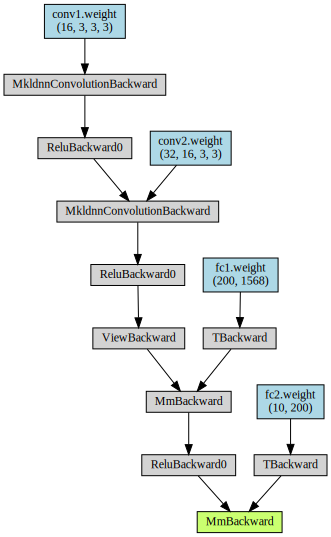

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1, self.conv2 = None, None
        self.fc1, self.fc2 = None, None
        ###############################################################################
        #       TODO : Set up the layer that you need to construct the model          #
        ###############################################################################
        self.conv1 = nn.Conv2d(3,16,(3,3),stride=2, bias=False)
        self.conv2 = nn.Conv2d(16,32,(3,3), stride=2, bias=False)
        
        self.fc1 = nn.Linear(1568,200, bias=False)
        self.fc2 = nn.Linear(200,10, bias=False)
        ###############################################################################
        #                            END TO DO                                        #
        ###############################################################################
        
        
    def forward(self, x):
        out = None
        ###############################################################################
        #            TODO : Implement the forward function. You should use            #
        #                   the layers you defined in __init__ and specify the        #
        #                   connectivity of those layers in forward()                 #
        ###############################################################################
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        out = self.fc2(x)
        ###############################################################################
        #                            END TO DO                                        #
        ###############################################################################        

        return out
        

model = CNN()
x = torch.zeros((BATCH_SIZE, 3, 32, 32))
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture

###### Train the model
Train the model and check the accuracy of training dataset and validation set

In [11]:
    criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.302 Acc 0.094
[  1/5] Training Step 100 Loss 2.265 Acc 0.109
[  1/5] Training Step 200 Loss 2.160 Acc 0.266
[  1/5] Training Step 300 Loss 2.027 Acc 0.281
[  1/5] Training Step 400 Loss 1.974 Acc 0.328
[  1/5] Training Step 500 Loss 1.892 Acc 0.219
[  1/5] Training Step 600 Loss 1.846 Acc 0.312
[  1/5] Training Step 700 Loss 1.586 Acc 0.438
[  1/5] Validate Step 015 Loss 1.834 Acc 0.351
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 2.139 Acc 0.234
[  2/5] Training Step 100 Loss 1.667 Acc 0.344
[  2/5] Training Step 200 Loss 1.689 Acc 0.328
[  2/5] Training Step 300 Loss 2.021 Acc 0.344
[  2/5] Training Step 400 Loss 1.827 Acc 0.422
[  2/5] Training Step 500 Loss 1.555 Acc 0.438
[  2/5] Training Step 600 Loss 1.562 Acc 0.391
[  2/5] Training Step 700 Loss 1.793 Acc 0.406
[  2/5] Validate Step 015 Loss 1.655 Acc 0.432
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Lo

## Part3 ModuleList API
In this part, you have to complete the implentation of CNN with ModuleList API and Module API.
The network should have the following architectures.
1. A convolution layer with 16 3\*3 filters, with stride 2
2. ReLU
3. A convolution layer with 32 3\*3 filters, with stride 2
4. ReLU
5. Flatten
6. A fully-connected layer produce tensor to 200 
7. ReLU
8. A fully-connected layer produce score to 10 (classes)
![](./resource/model_architecture.png)

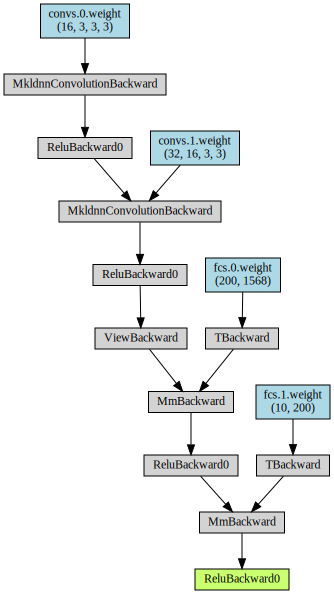

In [75]:
class ML(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs, self.fcs = nn.ModuleList(), nn.ModuleList()
        ###############################################################################
        #       TODO : Set up the layer that you need to construct the model          #
        ###############################################################################        
        
        
        self.conv1 = nn.Conv2d(3,16,(3,3),stride=2, bias=False)
        self.conv2 = nn.Conv2d(16,32,(3,3), stride=2, bias=False)
        
        self.fc1 = nn.Linear(1568,200, bias=False)
        self.fc2 = nn.Linear(200,10, bias=False)
        
        self.convs.append(self.conv1)
        self.convs.append(self.conv2)
        
        self.fcs.append(self.fc1)
        self.fcs.append(self.fc2)
        ###############################################################################
        #                            END TO DO                                        #
        ###############################################################################
        
        
    def forward(self, x):
        out = None
        ###############################################################################
        #            TODO : Implement the forward function. You should use            #
        #                   the layers you defined in __init__ and specify the        #
        #                   connectivity of those layers in forward()                 #
        ###############################################################################
        for layer in self.convs:
            x = F.relu(layer(x))
        #x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        x = flatten(x)
        
        for layer in self.fcs:
            x = F.relu(layer(x))
        out = x
        ###############################################################################
        #                            END TO DO                                        #
        ############################################################################### 
                    
        return out
    
model = ML()
x = torch.zeros((BATCH_SIZE, 3, 32, 32))
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture

### Train the model
Train the model and check the accuracy of training dataset and validation set

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.300 Acc 0.125


KeyboardInterrupt: 

## Part4 Sequential
In this part, you have to complete the implentation of CNN with Sequential API.
The network should have the following architectures.
1. A convolution layer with 16 3\*3 filters, with stride 2
2. ReLU
3. A convolution layer with 32 3\*3 filters, with stride 2
4. ReLU
5. Flatten
6. A fully-connected layer produce tensor to 200 
7. ReLU
8. A fully-connected layer produce score to 10 (classes)
![](./resource/model_architecture.png)

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

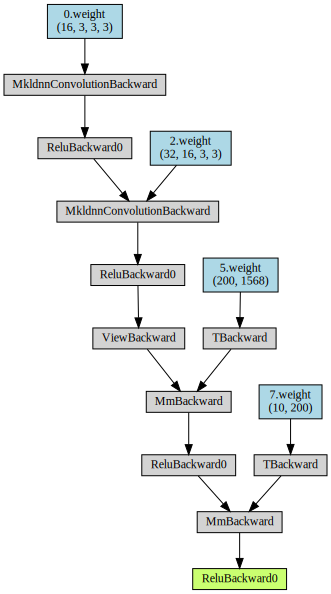

In [17]:
model = None
###############################################################################
#            TODO : Implement the Sequential API to complete the model        #
###############################################################################          
model = nn.Sequential(
            nn.Conv2d(3,16,(3,3),stride=2, bias=False),
            nn.ReLU(),
            nn.Conv2d(16,32,(3,3), stride=2, bias=False),
            nn.ReLU(),
            Flatten(),
            nn.Linear(1568,200, bias=False),
            nn.ReLU(),
            nn.Linear(200,10, bias=False),
            nn.ReLU())
        
        
###############################################################################
#                            END TO DO                                        #
###############################################################################  


x = torch.zeros((BATCH_SIZE, 3, 32, 32))
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture

### Train the model
Train the model and check the accuracy of training dataset and validation set

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.301 Acc 0.109
[  1/5] Training Step 100 Loss 2.268 Acc 0.266
[  1/5] Training Step 200 Loss 2.263 Acc 0.234
[  1/5] Training Step 300 Loss 2.069 Acc 0.281
[  1/5] Training Step 400 Loss 2.154 Acc 0.234
[  1/5] Training Step 500 Loss 2.089 Acc 0.281
[  1/5] Training Step 600 Loss 2.125 Acc 0.266
[  1/5] Training Step 700 Loss 2.176 Acc 0.328
[  1/5] Validate Step 015 Loss 1.988 Acc 0.318
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 1.791 Acc 0.312
[  2/5] Training Step 100 Loss 1.731 Acc 0.406
[  2/5] Training Step 200 Loss 1.691 Acc 0.422
[  2/5] Training Step 300 Loss 1.554 Acc 0.484
[  2/5] Training Step 400 Loss 1.681 Acc 0.359
[  2/5] Training Step 500 Loss 1.594 Acc 0.422
[  2/5] Training Step 600 Loss 1.939 Acc 0.344
[  2/5] Training Step 700 Loss 1.715 Acc 0.406
[  2/5] Validate Step 015 Loss 1.696 Acc 0.415
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Lo

## Part 5 CIFAR-10 open-ended challenge
In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10
### Baseline : 65% on Testing data!!!

In [29]:
model = None
optimizer = None
###############################################################################
#                               TODO                                          #
###############################################################################          
model = nn.Sequential(
            nn.Conv2d(3,16,(3,3),stride=1, bias=False),
            
            nn.ReLU(),
            
           
            
            nn.Conv2d(16,32,(3,3), stride=1, bias=False),
            
            nn.ReLU(),
            
            nn.Conv2d(32,64,(3,3), stride=2, bias=False),
            
            nn.ReLU(),
            
            nn.Conv2d(64,128,(3,3), stride=2, bias=False),
            
            nn.ReLU(),
            
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            
            
            Flatten(),
           
            
    
            #nn.Linear(10816,200, bias=False),
            #nn.ReLU(),
            
            #nn.Linear(800,200, bias=False),
            #nn.ReLU(),
    
            nn.Linear(1152,200, bias=False),
            nn.ReLU(),
    
            nn.Linear(200,10, bias=False),
            nn.ReLU())
###############################################################################
#                            END TO DO                                        #
###############################################################################  



criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-3, betas=(0.9,0.99))

trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)



---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.302 Acc 0.109
[  1/5] Training Step 100 Loss 1.706 Acc 0.453
[  1/5] Training Step 200 Loss 1.600 Acc 0.484
[  1/5] Training Step 300 Loss 1.158 Acc 0.578
[  1/5] Training Step 400 Loss 0.993 Acc 0.688
[  1/5] Training Step 500 Loss 1.222 Acc 0.531
[  1/5] Training Step 600 Loss 1.005 Acc 0.594
[  1/5] Training Step 700 Loss 0.938 Acc 0.703
[  1/5] Validate Step 015 Loss 1.031 Acc 0.632
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 1.001 Acc 0.656
[  2/5] Training Step 100 Loss 0.945 Acc 0.641
[  2/5] Training Step 200 Loss 0.965 Acc 0.703
[  2/5] Training Step 300 Loss 0.898 Acc 0.703
[  2/5] Training Step 400 Loss 0.642 Acc 0.766
[  2/5] Training Step 500 Loss 0.631 Acc 0.781
[  2/5] Training Step 600 Loss 0.708 Acc 0.750
[  2/5] Training Step 700 Loss 1.070 Acc 0.703
[  2/5] Validate Step 015 Loss 0.930 Acc 0.671
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Lo

### 請解釋你如何建構的

* 使用Sequential建構
* 新增了一層convolution，並且將stride改成1
* 使用batch normalization 和 max pooling
* 多增加一層full connecting layer
